# Hardening and deployment

> Part 3: Create production inference function

![position of this step in the lifecycle](/media/scope-deploy.svg)
> The blue boxes show the steps implemented in this notebook.

In [Part 2](/examples/simple/train), we trained our AI model. Now, it's time to create **G**eneral **R**obust **E**nd-to-end **A**utomated **T**rustworthy deployment.

## Create the inference function

Next to the prediction, we also return the top-n most influential words based on their weights.

In [1]:
import re
import numpy as np
from sklearn.pipeline import Pipeline
from great_ai.utilities import clean
from great_ai import (
    MultiLabelClassificationOutput,
    ClassificationOutput,
    GreatAI,
    use_model,
    parameter,
)


@GreatAI.create
@use_model("small-domain-prediction", version="latest")
@parameter("target_confidence", validate=lambda c: 0 <= c <= 100)
def predict_domain(
    text: str, model: Pipeline, target_confidence: int = 50
) -> MultiLabelClassificationOutput:
    """
    Predict the scientific domain of the input text.
    Return labels until their sum likelihood is larger than `target_confidence`.
    """

    preprocessed = re.sub(r"[^a-zA-Z\s]", "", clean(text, convert_to_ascii=True))
    features = model.named_steps["vectorizer"].transform([preprocessed])
    prediction = model.named_steps["classifier"].predict_proba(features)[0]

    best_classes = sorted(enumerate(prediction), key=lambda v: v[1], reverse=True)

    results = MultiLabelClassificationOutput()
    for class_index, probability in best_classes:
        results.labels.append(
            get_label(
                model=model,
                features=features,
                class_index=class_index,
                probability=probability,
            )
        )

        if sum(r.confidence for r in results.labels) >= target_confidence:
            break

    return results


def get_label(
    model: Pipeline, features: np.ndarray, class_index: int, probability: float
) -> ClassificationOutput:
    return ClassificationOutput(
        label=model.named_steps["classifier"].classes_[class_index],
        confidence=round(probability * 100),
        explanation=[
            word
            for _, word in sorted(
                (
                    (weight, word)
                    for weight, word, count in zip(
                        model.named_steps["classifier"].feature_log_prob_[class_index],
                        model.named_steps["vectorizer"].get_feature_names_out(),
                        features.A[0],
                    )
                    if count > 0
                ),
                reverse=True,
            )
        ][:5],
    )

Environment variable ENVIRONMENT is not set, defaulting to development mode ‼️
Cannot find credentials files, defaulting to using ParallelTinyDbDriver
The selected tracing database (ParallelTinyDbDriver) is not recommended for production
Cannot find credentials files, defaulting to using LargeFileLocal
GreatAI (v0.1.6): configured ✅
  🔩 tracing_database: ParallelTinyDbDriver
  🔩 large_file_implementation: LargeFileLocal
  🔩 is_production: False
  🔩 should_log_exception_stack: True
  🔩 prediction_cache_size: 512
  🔩 dashboard_table_size: 50
You still need to check whether you follow all best practices before trusting your deployment.
> Find out more at https://se-ml.github.io/practices
Fetching cached versions of small-domain-prediction
Latest version of small-domain-prediction is 2 (from versions: 0, 1, 2)
File small-domain-prediction-2 found in cache


## Check accuracy on the test split

Anything under `if __name__ == "__main__":` will not be run when the script is executed by the `great-ai` CLI app. This, combined with `query_ground_truth` and the `/traces/{trace_id}/feedback` endpoint are ideal for creating a continuous-integration job for checking the quality of the model before deployment.

100%|██████████| 12272/12272 [01:10<00:00, 174.77it/s]


                       precision    recall  f1-score   support

                  Art       0.54      0.38      0.45       126
              Biology       0.77      0.84      0.80      1215
             Business       0.47      0.73      0.57       311
            Chemistry       0.82      0.67      0.74      1205
     Computer Science       0.77      0.76      0.76      1277
            Economics       0.69      0.55      0.61       270
          Engineering       0.55      0.52      0.53       754
Environmental Science       0.56      0.55      0.55       227
            Geography       0.54      0.39      0.45       276
              Geology       0.74      0.67      0.70       265
              History       0.35      0.18      0.24       140
    Materials Science       0.72      0.81      0.76      1011
          Mathematics       0.77      0.70      0.74       498
             Medicine       0.96      0.77      0.86      2835
           Philosophy       0.57      0.06      0.10  

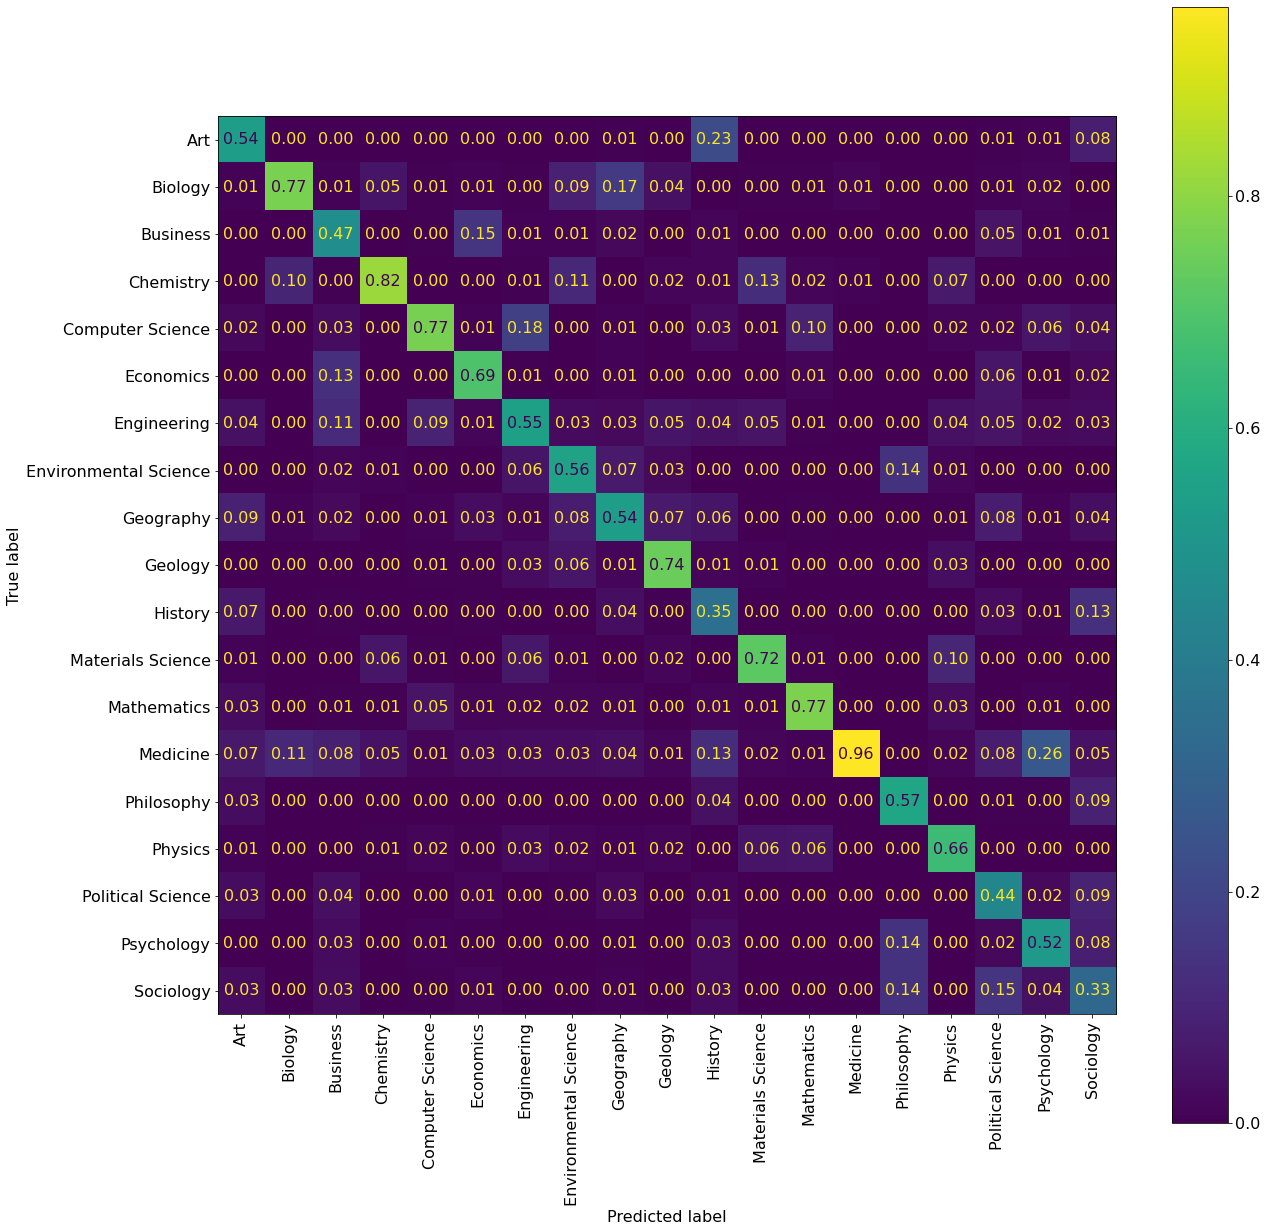

In [2]:
if __name__ == "__main__":
    from great_ai import query_ground_truth
    from sklearn import metrics

    data = query_ground_truth("test")

    X = [d.input for d in data]
    y_actual = [d.feedback for d in data]

    y_predicted = [
        d.output.labels[0].label
        for d in predict_domain.process_batch(X, do_not_persist_traces=True)
    ]
    y_actual_aligned = [p if p in a else a[0] for p, a in zip(y_predicted, y_actual)]

    import matplotlib.pyplot as plt

    # Configure matplotlib to have nice, high-resolution charts
    %matplotlib inline
    plt.rcParams["figure.figsize"] = (19, 18)
    plt.rcParams["figure.facecolor"] = "white"
    plt.rcParams["font.size"] = 16
    plt.rcParams["axes.xmargin"] = 0

    print(metrics.classification_report(y_actual_aligned, y_predicted))
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_true=y_actual_aligned,
        y_pred=y_predicted,
        xticks_rotation="vertical",
        normalize="pred",
        values_format=".2f",
    )

    plt.tight_layout()
    plt.savefig("ss-confusion.png", dpi=600)